In [1]:
import geopandas as gpd
import pandas as pd

# Load each shapefile using geopandas
states_legal_amazon = gpd.read_file('../data/states_legal_amazon/states_legal_amazon.shp')
brazilian_legal_amazon = gpd.read_file('../data/brazilian_legal_amazon')
conservation_units_legal_amazon = gpd.read_file('../data/conservation_units_legal_amazon/conservation_units_legal_amazon.shp')
deter_amz_public_2024out8 = gpd.read_file('data2/deter-amz-deter-public.shp')
ac_municipios_2022 = gpd.read_file('../data/malhas_regionais_ibge/AC_Municipios_2022/AC_Municipios_2022.shp')


In [2]:
print(states_legal_amazon.head(4))
print(brazilian_legal_amazon.head(4))
print(conservation_units_legal_amazon.head(4))
print(deter_amz_public_2024out8.head(4))
print(ac_municipios_2022.head(4))

   id      nome sigla geocodigo  \
0   2  Rondônia    RO        11   
1   3      Acre    AC        12   
2   4  Amazonas    AM        13   
3   5   Roraima    RR        14   

                                            geometry  
0  MULTIPOLYGON (((-60.71438 -13.69188, -60.72165...  
1  MULTIPOLYGON (((-66.62515 -9.9029, -66.62446 -...  
2  MULTIPOLYGON (((-73.78698 -7.09645, -73.73817 ...  
3  MULTIPOLYGON (((-63.37171 2.21232, -63.37086 2...  
        sprarea    sprperimet sprclasse  \
0  5.068004e+12  1.877763e+07  AM_Legal   

                                            geometry  
0  POLYGON ((-44.04149 -2.46528, -43.95183 -6.754...  
    id                                           nome  \
0  366                 ESTAÇÃO ECOLÓGICA DO GRÃO PARÁ   
1   30         RESERVA EXTRATIVISTA RIO PRETO-JACUNDÁ   
2   40            RESERVA EXTRATIVISTA DO MéDIO PURúS   
3  789  ÁREA DE PROTEÇÃO AMBIENTAL - BAIXO RIO BRANCO   

                    categoria grupo    esfera ano_cria  \
0       

ADF Statistic: -6.516079228096373
p-value: 1.070530162216638e-08


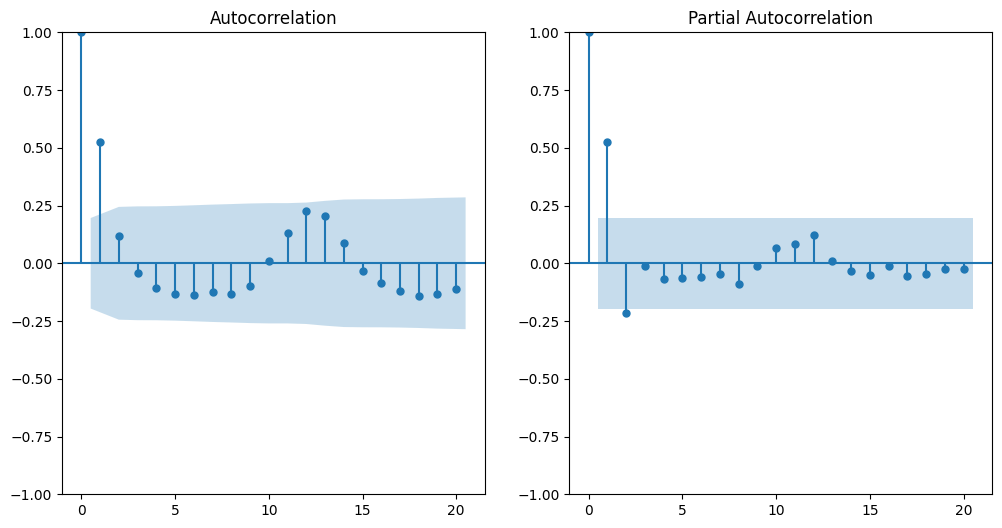

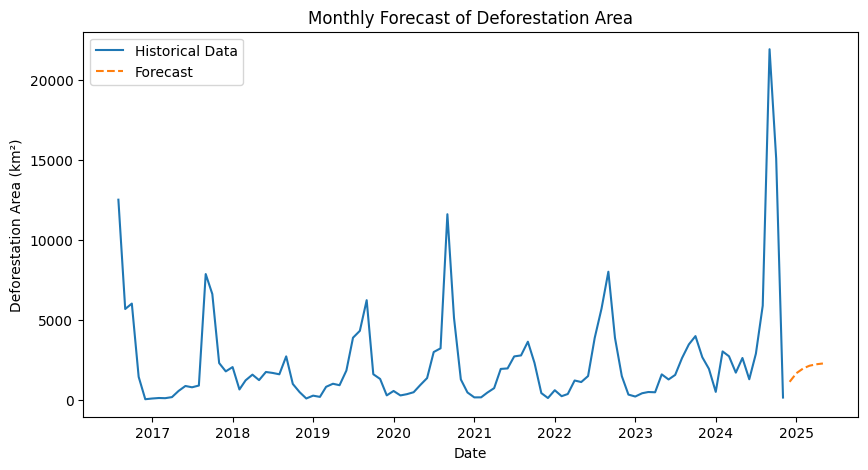

In [3]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Step 1: Load and aggregate the data by month
# Assume `deter_data` is your DataFrame for deter_amz_public_2024out8 data.
deter_data = deter_amz_public_2024out8  # Replace with the actual loaded DataFrame
deter_data['VIEW_DATE'] = pd.to_datetime(deter_data['VIEW_DATE'])

# Aggregate the total affected area per month
monthly_data = deter_data.groupby(deter_data['VIEW_DATE'].dt.to_period('M'))['AREAMUNKM'].sum().to_timestamp()

# Step 2: Check for stationarity
# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(monthly_data)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# If data is non-stationary, take the first difference
if adf_test[1] > 0.05:
    monthly_data = monthly_data.diff().dropna()

# Step 3: Plot ACF and PACF to determine p and q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(monthly_data, ax=plt.gca())
plt.subplot(122)
plot_pacf(monthly_data, ax=plt.gca())
plt.show()

# Based on ACF/PACF plot, choose p and q (example: p=1, d=1, q=1)
p, d, q = 1, 1, 1

# Step 4: Fit the ARIMA model
model = ARIMA(monthly_data, order=(p, d, q))
arima_result = model.fit()

# Step 5: Forecast for the next 6 months
forecast_horizon = 6
forecast = arima_result.forecast(steps=forecast_horizon)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(monthly_data, label='Historical Data')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Deforestation Area (km²)')
plt.title('Monthly Forecast of Deforestation Area')
plt.legend()
plt.show()


/home/prathiba/pra/GeorgiaTech/Fall24/CSE6242/Data_Analysis_Project/.environment/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/prathiba/pra/GeorgiaTech/Fall24/CSE6242/Data_Analysis_Project/.environment/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/prathiba/pra/GeorgiaTech/Fall24/CSE6242/Data_Analysis_Project/.environment/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 2496.415892053097
Mean Absolute Percentage Error (MAPE): 114.52%


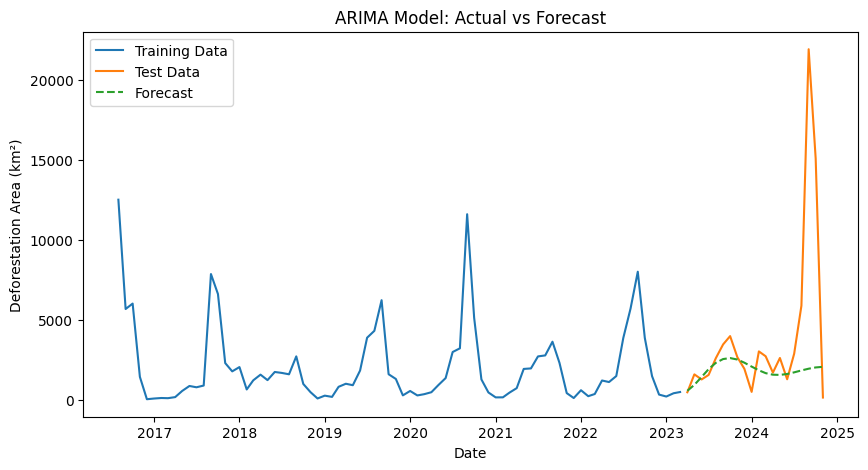

In [4]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Step 1: Load and aggregate the data by month
# Assume `deter_data` is your DataFrame for deter_amz_public_2024out8 data.
deter_data = deter_amz_public_2024out8  # Replace with the actual loaded DataFrame
deter_data['VIEW_DATE'] = pd.to_datetime(deter_data['VIEW_DATE'])

# Aggregate the total affected area per month
monthly_data = deter_data.groupby(deter_data['VIEW_DATE'].dt.to_period('M'))['AREAMUNKM'].sum().to_timestamp()

# Step 2: Check for stationarity and differencing if necessary
# Perform the Augmented Dickey-Fuller test
adf_test = adfuller(monthly_data)
if adf_test[1] > 0.05:
    monthly_data = monthly_data.diff().dropna()  # Make the data stationary

# Step 3: Train-test split (e.g., 80% train, 20% test)
train_size = int(len(monthly_data) * 0.8)
train, test = monthly_data[:train_size], monthly_data[train_size:]

# Step 4: Fit ARIMA model on training data
# Based on ACF/PACF observations, let's assume p=1, d=1, q=1 for now
p, d, q = 2, 0, 2
model = ARIMA(train, order=(p, d, q))
arima_result = model.fit()

# Step 5: Forecast for the test period
forecast = arima_result.forecast(steps=len(test))

# Step 6: Evaluate the model
mae = mean_absolute_error(test, forecast)
mape = mean_absolute_percentage_error(test, forecast)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# Step 7: Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Deforestation Area (km²)')
plt.title('ARIMA Model: Actual vs Forecast')
plt.legend()
plt.show()


2024-11-14 16:34:24.717525: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 16:34:24.719680: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 16:34:24.766924: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-14 16:34:24.832645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731620064.882426  166910 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731620064.88

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0197 - val_loss: 0.0826
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0153 - val_loss: 0.0736
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0107 - val_loss: 0.0669
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0091 - val_loss: 0.0646
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0104 - val_loss: 0.0661
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0095 - val_loss: 0.0680
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0105 - val_loss: 0.0691
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0079 - val_loss: 0.0690
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0080 - val_loss: 0.0682
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0092 - val_loss: 0.0679
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0088 - val_loss: 0.0668
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0079 - val_loss: 0.0688


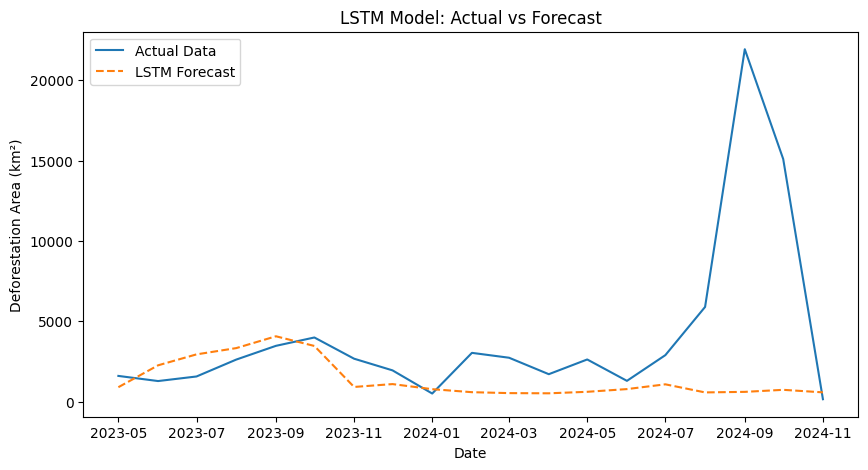

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import setuptools.dist

# Step 1: Load and prepare the data
# Assume `deter_data` is your DataFrame for deter_amz_public_2024out8 data.
deter_data['VIEW_DATE'] = pd.to_datetime(deter_data['VIEW_DATE'])
monthly_data = deter_data.groupby(deter_data['VIEW_DATE'].dt.to_period('M'))['AREAMUNKM'].sum().to_timestamp()

# Scale the data for LSTM (normalizing values to range [0, 1])
scaler = MinMaxScaler(feature_range=(0, 1))
monthly_data_scaled = scaler.fit_transform(monthly_data.values.reshape(-1, 1))

# Convert series to supervised learning format
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Parameters for LSTM
seq_length = 6  # Using the past 12 months to predict the next month
X, y = create_sequences(monthly_data_scaled, seq_length)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_length, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Step 3: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Step 4: Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)  # Transform predictions back to original scale
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Transform actual values back

# Step 5: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(monthly_data.index[-len(y_test):], y_test, label='Actual Data')
plt.plot(monthly_data.index[-len(y_test):], y_pred, label='LSTM Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Deforestation Area (km²)')
plt.title('LSTM Model: Actual vs Forecast')
plt.legend()
plt.show()


Epoch 1/50


/home/prathiba/pra/GeorgiaTech/Fall24/CSE6242/Data_Analysis_Project/.environment/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0765
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0534 
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0651 
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0375 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0312 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0530 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0548 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0333 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0358 
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0241
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0425 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0354 
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0291 
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0246 
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0335 
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/st

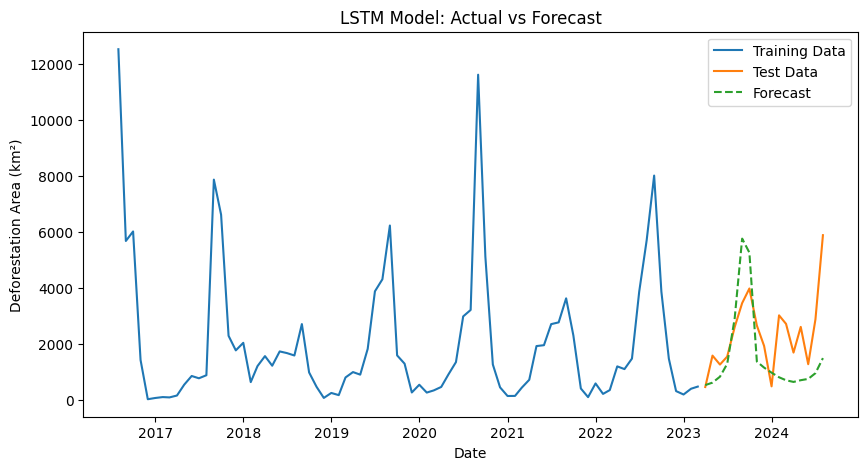

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Load and aggregate the data by month
deter_data = deter_amz_public_2024out8  # Replace with the actual loaded DataFrame
deter_data['VIEW_DATE'] = pd.to_datetime(deter_data['VIEW_DATE'])


monthly_data = deter_data.groupby(deter_data['VIEW_DATE'].dt.to_period('M'))['AREAMUNKM'].sum().to_timestamp()
monthly_data = monthly_data.drop(['2024-09-01', '2024-10-01', '2024-11-01'])
# Step 2: Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
monthly_data_scaled = scaler.fit_transform(monthly_data.values.reshape(-1, 1))

# Step 3: Prepare the data for LSTM
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # Sequence length of 12 months
X, y = create_sequences(monthly_data_scaled, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Define and fit the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, activation='sigmoid', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Step 5: Forecast using the test data
y_pred = model.predict(X_test)

# Rescale the predictions and test values back to the original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# Step 7: Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(monthly_data.index[:train_size + seq_length], scaler.inverse_transform(monthly_data_scaled[:train_size + seq_length]), label='Training Data')
plt.plot(monthly_data.index[train_size + seq_length:], y_test_rescaled, label='Test Data')
plt.plot(monthly_data.index[train_size + seq_length:], y_pred_rescaled, label='Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Deforestation Area (km²)')
plt.title('LSTM Model: Actual vs Forecast')
plt.legend()
plt.show()


In [21]:
monthly_data

VIEW_DATE
2016-08-01    12524.114299
2016-09-01     5683.871923
2016-10-01     6023.486244
2016-11-01     1437.783446
2016-12-01       38.490006
                  ...     
2024-07-01     2889.083444
2024-08-01     5890.189470
2024-09-01    21940.262277
2024-10-01    15100.299842
2024-11-01      143.399924
Freq: MS, Name: AREAMUNKM, Length: 100, dtype: float64